# Recurrant Neural Network

In [1]:
# Import necessary libraries
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
# Clone the dataset from GitHub
!git clone https://github.com/Muhammad-Ikhwan-Fathulloh/Hands-On-NLP-Super-Class-Batch1.git

# Define path to data directory
data_path = 'Hands-On-NLP-Super-Class-Batch1/RNN/data/names/*.txt'

Cloning into 'Hands-On-NLP-Super-Class-Batch1'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 110 (delta 34), reused 86 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (110/110), 2.78 MiB | 3.68 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [3]:
# Function to find files in the dataset
def findFiles(path):
    return glob.glob(path)

print(findFiles(data_path))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

['Hands-On-NLP-Super-Class-Batch1/RNN/data/names/Chinese.txt', 'Hands-On-NLP-Super-Class-Batch1/RNN/data/names/Czech.txt', 'Hands-On-NLP-Super-Class-Batch1/RNN/data/names/Irish.txt', 'Hands-On-NLP-Super-Class-Batch1/RNN/data/names/German.txt', 'Hands-On-NLP-Super-Class-Batch1/RNN/data/names/Japanese.txt', 'Hands-On-NLP-Super-Class-Batch1/RNN/data/names/Vietnamese.txt', 'Hands-On-NLP-Super-Class-Batch1/RNN/data/names/Russian.txt', 'Hands-On-NLP-Super-Class-Batch1/RNN/data/names/Greek.txt', 'Hands-On-NLP-Super-Class-Batch1/RNN/data/names/Polish.txt', 'Hands-On-NLP-Super-Class-Batch1/RNN/data/names/Portuguese.txt', 'Hands-On-NLP-Super-Class-Batch1/RNN/data/names/Arabic.txt', 'Hands-On-NLP-Super-Class-Batch1/RNN/data/names/Dutch.txt', 'Hands-On-NLP-Super-Class-Batch1/RNN/data/names/French.txt', 'Hands-On-NLP-Super-Class-Batch1/RNN/data/names/Italian.txt', 'Hands-On-NLP-Super-Class-Batch1/RNN/data/names/English.txt', 'Hands-On-NLP-Super-Class-Batch1/RNN/data/names/Spanish.txt', 'Hands-On-NL

In [4]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(data_path):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

# Find letter index from all_letters
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [5]:
# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(output)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

tensor([[-2.8508, -3.1046, -2.8252, -2.9433, -2.8043, -2.9000, -3.0022, -2.9320,
         -2.9127, -2.8298, -2.8687, -2.8900, -2.8792, -2.8391, -2.9134, -2.8085,
         -2.7960, -2.9792]], grad_fn=<LogSoftmaxBackward0>)
('Korean', 16)


In [6]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

criterion = nn.NLLLoss()
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

n_iters = 100000
print_every = 5000
plot_every = 1000
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

category = Scottish / line = Macdonald
category = Italian / line = Nicolosi
category = Chinese / line = Gwock
category = Arabic / line = Kouri
category = Czech / line = Antonowitsch
category = Greek / line = Kaloxylos
category = English / line = Wrightson
category = Scottish / line = Miller
category = English / line = Norbury
category = Japanese / line = Morita
5000 5% (0m 15s) 2.9117 Cavey / Arabic ✗ (French)
10000 10% (0m 24s) 1.2628 Chin / Korean ✓
15000 15% (0m 33s) 2.0882 Schmeling / Irish ✗ (German)
20000 20% (0m 42s) 1.3664 Dubhshlaine / French ✗ (Irish)
25000 25% (0m 50s) 1.1300 Assen / Dutch ✓
30000 30% (0m 59s) 0.4356 Sokolof / Polish ✓
35000 35% (1m 8s) 1.7651 Gebara / Japanese ✗ (Spanish)
40000 40% (1m 17s) 0.3183 Apeldoorn / Dutch ✓
45000 45% (1m 26s) 0.3412 O'Byrne / Irish ✓
50000 50% (1m 35s) 0.0007 Fotopoulos / Greek ✓
55000 55% (1m 43s) 0.6788 Marquerink / Dutch ✓
60000 60% (1m 52s) 0.2687 Duong / Vietnamese ✓
65000 65% (2m 1s) 1.1764 Lafrentz / German ✓
70000 70% (2m 

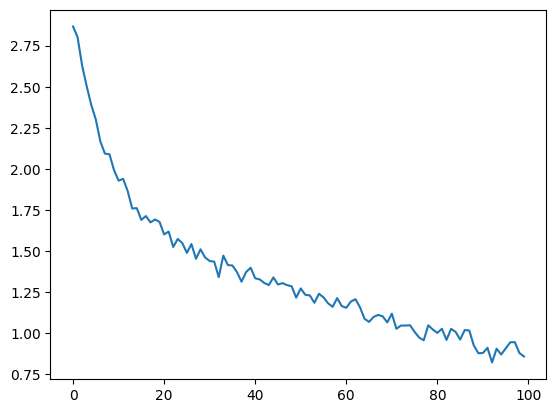

In [7]:
plt.figure()
plt.plot(all_losses)

Dari grafik ini, terlihat bahwa nilai loss model menurun seiring bertambahnya jumlah epoch. Pada awal pelatihan, nilai loss tinggi, sekitar 2.75, namun secara bertahap menurun secara signifikan hingga di bawah 1.0 pada akhir pelatihan (sekitar epoch ke-100).



In [8]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

<ipython-input-9-bdfa38b7f914>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-9-bdfa38b7f914>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


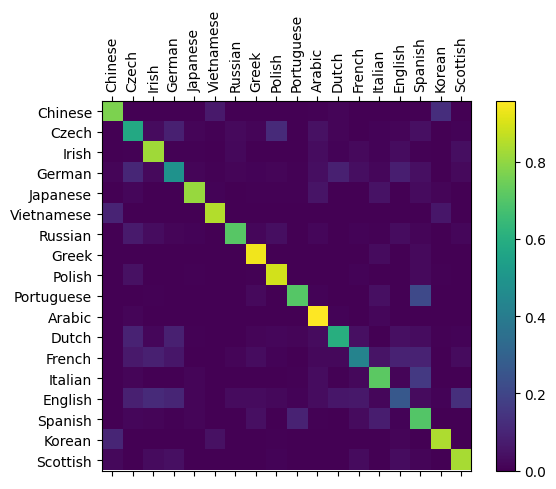

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

In [10]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

print(predict('Dovesky'))
print(predict('Jackson'))
print(predict('Satoshi'))


> Dovesky
(-0.42) Russian
(-1.23) Czech
(-3.65) English
None

> Jackson
(-0.30) Scottish
(-1.96) English
(-3.22) Czech
None

> Satoshi
(-0.25) Japanese
(-2.05) Arabic
(-2.90) Italian
None


In [11]:
torch.save(rnn.state_dict(), 'rnn.pt')